In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds

import numpy as np
import matplotlib.pyplot as plt
import os
from datetime import datetime

from data_preprocessing import *
from models import SimpleCNN, ResNet
from models.utils import TestCallback, SaveModelWeights
from cutout.cutout import DynamicCutoutLayer, RandomCutoutLayer
from cutout.utils import zero_out, zero_out_batched
# from cutout.mult_cutout import CutOut

2024-04-14 19:47:31.197647: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
BATCH_SIZE = 128
EPOCHS = 2

In [3]:
(train_ds, test_ds), info_ds = tfds.load('cifar10', split=['train', 'test'],
                                          as_supervised=True, with_info=True,
                                          shuffle_files=True)

INFO:absl:Load dataset info from /home/martin/tensorflow_datasets/cifar10/3.0.2
INFO:absl:Reusing dataset cifar10 (/home/martin/tensorflow_datasets/cifar10/3.0.2)
2024-04-14 19:47:32.962132: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.
INFO:absl:Constructing tf.data.Dataset cifar10 for split ['train', 'test'], from /home/martin/tensorflow_datasets/cifar10/3.0.2


In [4]:
label_names = info_ds.features['label'].names
print(label_names)
# tfds.show_examples(train_ds, info_ds, rows=1, cols=4)

['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


In [5]:
rnd_cutout = RandomCutoutLayer(mask_size=10, cutout_prob=1, shape='square')

train_data = train_ds.skip(10000).apply(lambda ds: 
                            prepare_dataset(ds, batch_size=BATCH_SIZE ,kind="train", cutout_layer=rnd_cutout))
val_data = train_ds.take(10000).apply(lambda ds:
                            prepare_dataset(ds, batch_size=BATCH_SIZE ,kind="val"))
test_data = test_ds.apply(lambda ds:
                          prepare_dataset(ds, batch_size=BATCH_SIZE ,kind="test"))

2024-04-14 19:47:33.818750: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int64 and shape [1]
	 [[{{node Placeholder/_4}}]]
2024-04-14 19:47:33.819261: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype string and shape [1]
	 [[{{node Placeholder/_2}}]]
2024-04-14 19:47:34.923454: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline s

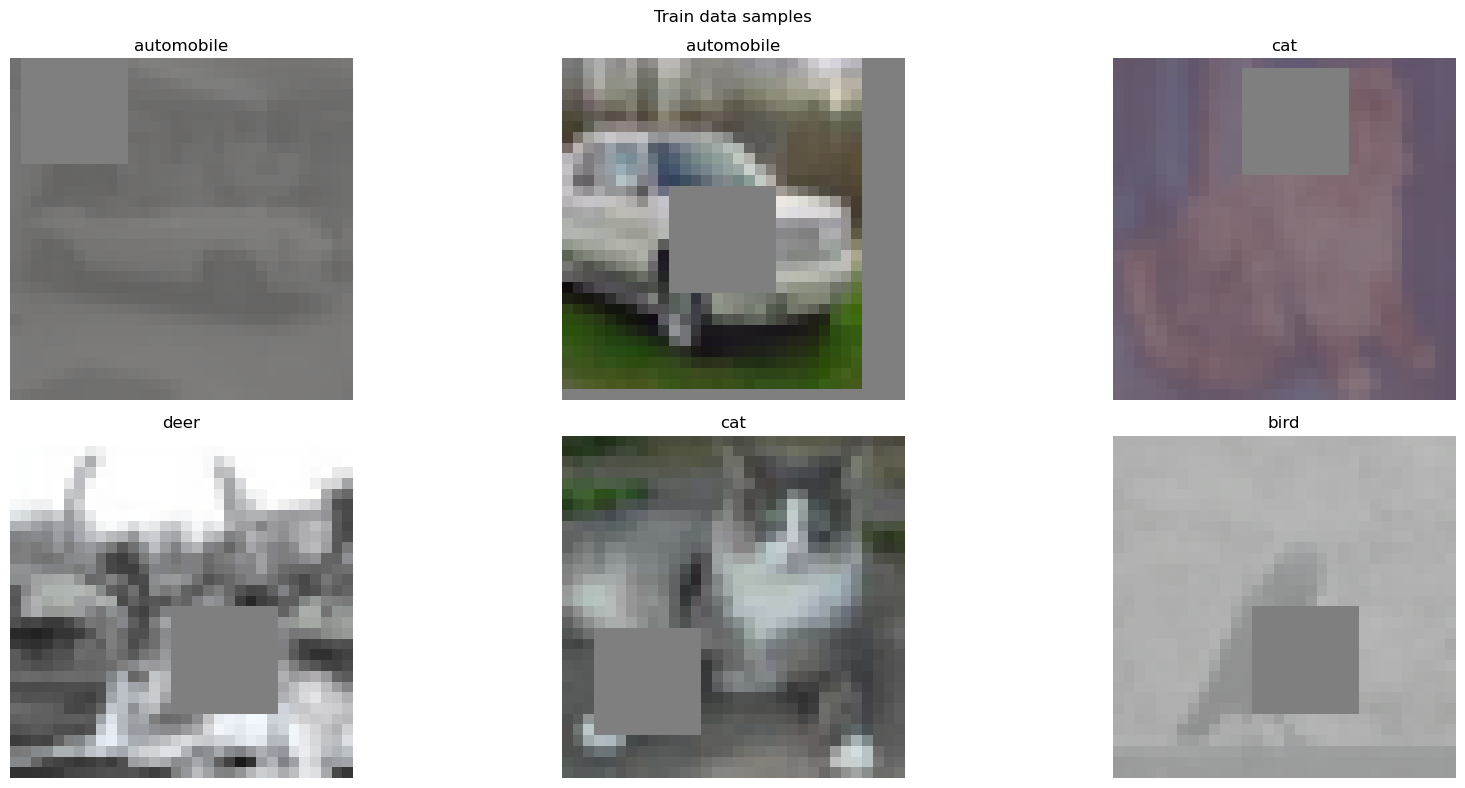

2024-04-14 19:47:35.208305: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype string and shape [1]
	 [[{{node Placeholder/_1}}]]
2024-04-14 19:47:35.208695: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype string and shape [1]
	 [[{{node Placeholder/_2}}]]


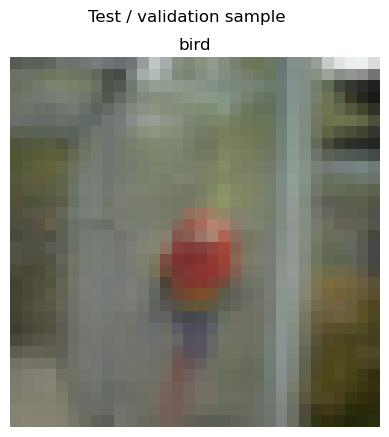

In [6]:
import matplotlib.pyplot as plt

# samples from train data
num_samples = 6
max_plots_per_row = 3  
num_columns = min(num_samples, max_plots_per_row)
num_rows = (num_samples + max_plots_per_row - 1) // max_plots_per_row 
fig_width = num_columns * 6
fig_height = num_rows * 4
# create the subplots
fig, axes = plt.subplots(num_rows, num_columns, figsize=(fig_width, fig_height))
fig.suptitle('Train data samples')
# flatten the array of axes
# ensure its an array in case of single sample
axes = np.asarray(axes).flatten()

for i, (image, label) in enumerate(train_data.take(num_samples)):
    axes[i].imshow((image[0] + 1) / 2)
    # set the title to the int of the one-hot encoding
    label = label_names[np.argmax(label[0])]
    axes[i].set_title(label)
    axes[i].axis('off')
plt.tight_layout()
plt.show()
# image from test data
img_test, label_test = iter(test_data.take(1)).next()
plt.imshow((img_test[0] + 1) / 2)
plt.suptitle('Test / validation sample')
plt.title(f"{label_names[np.argmax(label_test[0])]}")
plt.axis('off')
plt.show()

In [7]:
simple_CNN = SimpleCNN()
simple_CNN.build((None, 32, 32, 3))  # Necessary to create the model's weights
simple_CNN.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
# model.summary()

res_net18 = ResNet((32, 32, 3), 10, type='resnet18')
res_net18.build((None, 32, 32, 3))
res_net18.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
# res_net18.summary()

res_net34 = ResNet((32, 32, 3), 10, type='resnet34')
res_net34.build((None, 32, 32, 3))
res_net34.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
# res_net34.summary()

In [8]:
# test with less data
train_split = train_data.take(10)
val_split = val_data.take(1)
test_split = test_data.take(10)
## -----------------------------------------------------------
test_res_callback_sCNN = TestCallback(test_data=test_split)
test_res_callback_res18 = TestCallback(test_data=test_split)
test_res_callback_res34 = TestCallback(test_data=test_split)

save_weights_callback = SaveModelWeights(n=2, save_path='trained_models/' )

history_sCNN = simple_CNN.fit(train_split, epochs=EPOCHS, validation_data=val_split, callbacks=[test_res_callback_sCNN, save_weights_callback])
history_res18 = res_net18.fit(train_split, epochs=EPOCHS, validation_data=val_split, callbacks=[test_res_callback_res18, save_weights_callback])
history_res34 = res_net34.fit(train_split, epochs=EPOCHS, validation_data=val_split, callbacks=[test_res_callback_res34, save_weights_callback])

# Ensure the directory exists and save the model weights
os.makedirs('trained_models', exist_ok=True)
timestamp = datetime.now().strftime("%Y%m%d-%H%M%S") 
simple_CNN.save_weights(f'trained_models/simpleCNN_{timestamp}.h5')
res_net18.save_weights(f'trained_models/resnet18_{timestamp}.h5')
res_net34.save_weights(f'trained_models/resnet34_{timestamp}.h5')

Epoch 1/2


2024-04-14 19:47:36.457418: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [1]
	 [[{{node Placeholder/_3}}]]
2024-04-14 19:47:36.458212: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [1]
	 [[{{node Placeholder/_0}}]]


10/10 [==============================] - ETA: 0s - loss: 2.2646 - accuracy: 0.1648

2024-04-14 19:47:38.833912: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
2024-04-14 19:47:38.958584: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype string and shape [1]
	 [[{{node Placeholder/_1}}]]
2024-04-14 19:47:38.959412: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a va

Epoch 0: Testing loss: 2.139047145843506, accuracy: 0.21875
10/10 [==============================] - 4s 240ms/step - loss: 2.2646 - accuracy: 0.1648 - val_loss: 2.2032 - val_accuracy: 0.1641 - epoch: 0.0000e+00 - test_loss: 2.1390 - test_accuracy: 0.2188
Epoch 2/2
10/10 [==============================] - ETA: 0s - loss: 2.1746 - accuracy: 0.2031

2024-04-14 19:47:41.637582: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
2024-04-14 19:47:42.070334: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


Epoch 1: Testing loss: 2.039283275604248, accuracy: 0.265625
10/10 [==============================] - 3s 175ms/step - loss: 2.1746 - accuracy: 0.2031 - val_loss: 2.0323 - val_accuracy: 0.2578 - epoch: 1.0000 - test_loss: 2.0393 - test_accuracy: 0.2656
Epoch 1/2
 9/10 [==========================>...] - ETA: 0s - loss: 2.5566 - accuracy: 0.1684

2024-04-14 19:47:55.776454: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


10/10 [==============================] - ETA: 0s - loss: 2.5169 - accuracy: 0.1742

2024-04-14 19:47:57.002255: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


Epoch 0: Testing loss: 2.2698793411254883, accuracy: 0.19296875596046448
10/10 [==============================] - 11s 693ms/step - loss: 2.5169 - accuracy: 0.1742 - val_loss: 2.2683 - val_accuracy: 0.2109 - epoch: 0.0000e+00 - test_loss: 2.2699 - test_accuracy: 0.1930
Epoch 2/2
 9/10 [==========================>...] - ETA: 0s - loss: 2.2203 - accuracy: 0.2005

2024-04-14 19:48:03.601300: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


10/10 [==============================] - ETA: 0s - loss: 2.2037 - accuracy: 0.2070

2024-04-14 19:48:04.671972: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


Epoch 1: Testing loss: 2.19244647026062, accuracy: 0.25078123807907104
10/10 [==============================] - 8s 698ms/step - loss: 2.2037 - accuracy: 0.2070 - val_loss: 2.2034 - val_accuracy: 0.2422 - epoch: 1.0000 - test_loss: 2.1924 - test_accuracy: 0.2508
Epoch 1/2
 9/10 [==========================>...] - ETA: 0s - loss: 2.5659 - accuracy: 0.1319

2024-04-14 19:48:19.738528: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


10/10 [==============================] - ETA: 0s - loss: 2.5343 - accuracy: 0.1391

2024-04-14 19:48:21.696521: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


Epoch 0: Testing loss: 2.300468683242798, accuracy: 0.10546875
10/10 [==============================] - 18s 1s/step - loss: 2.5343 - accuracy: 0.1391 - val_loss: 2.2995 - val_accuracy: 0.1406 - epoch: 0.0000e+00 - test_loss: 2.3005 - test_accuracy: 0.1055
Epoch 2/2
 9/10 [==========================>...] - ETA: 0s - loss: 2.2172 - accuracy: 0.1701

2024-04-14 19:48:32.216375: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


10/10 [==============================] - ETA: 0s - loss: 2.2092 - accuracy: 0.1742

2024-04-14 19:48:33.371123: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


Epoch 1: Testing loss: 2.301809787750244, accuracy: 0.10859374701976776
10/10 [==============================] - 12s 1s/step - loss: 2.2092 - accuracy: 0.1742 - val_loss: 2.2954 - val_accuracy: 0.1016 - epoch: 1.0000 - test_loss: 2.3018 - test_accuracy: 0.1086


In [9]:
print(history_sCNN.params, history_sCNN.history.keys())
print(history_sCNN.history['val_accuracy'])

print(history_res18.params, history_res18.history.keys())
print(history_res18.history['val_accuracy'])

print(history_res34.params, history_res34.history.keys())
print(history_res34.history['val_accuracy'])

{'verbose': 1, 'epochs': 2, 'steps': 10} dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy', 'epoch', 'test_loss', 'test_accuracy'])
[0.1640625, 0.2578125]
{'verbose': 1, 'epochs': 2, 'steps': 10} dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy', 'epoch', 'test_loss', 'test_accuracy'])
[0.2109375, 0.2421875]
{'verbose': 1, 'epochs': 2, 'steps': 10} dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy', 'epoch', 'test_loss', 'test_accuracy'])
[0.140625, 0.1015625]


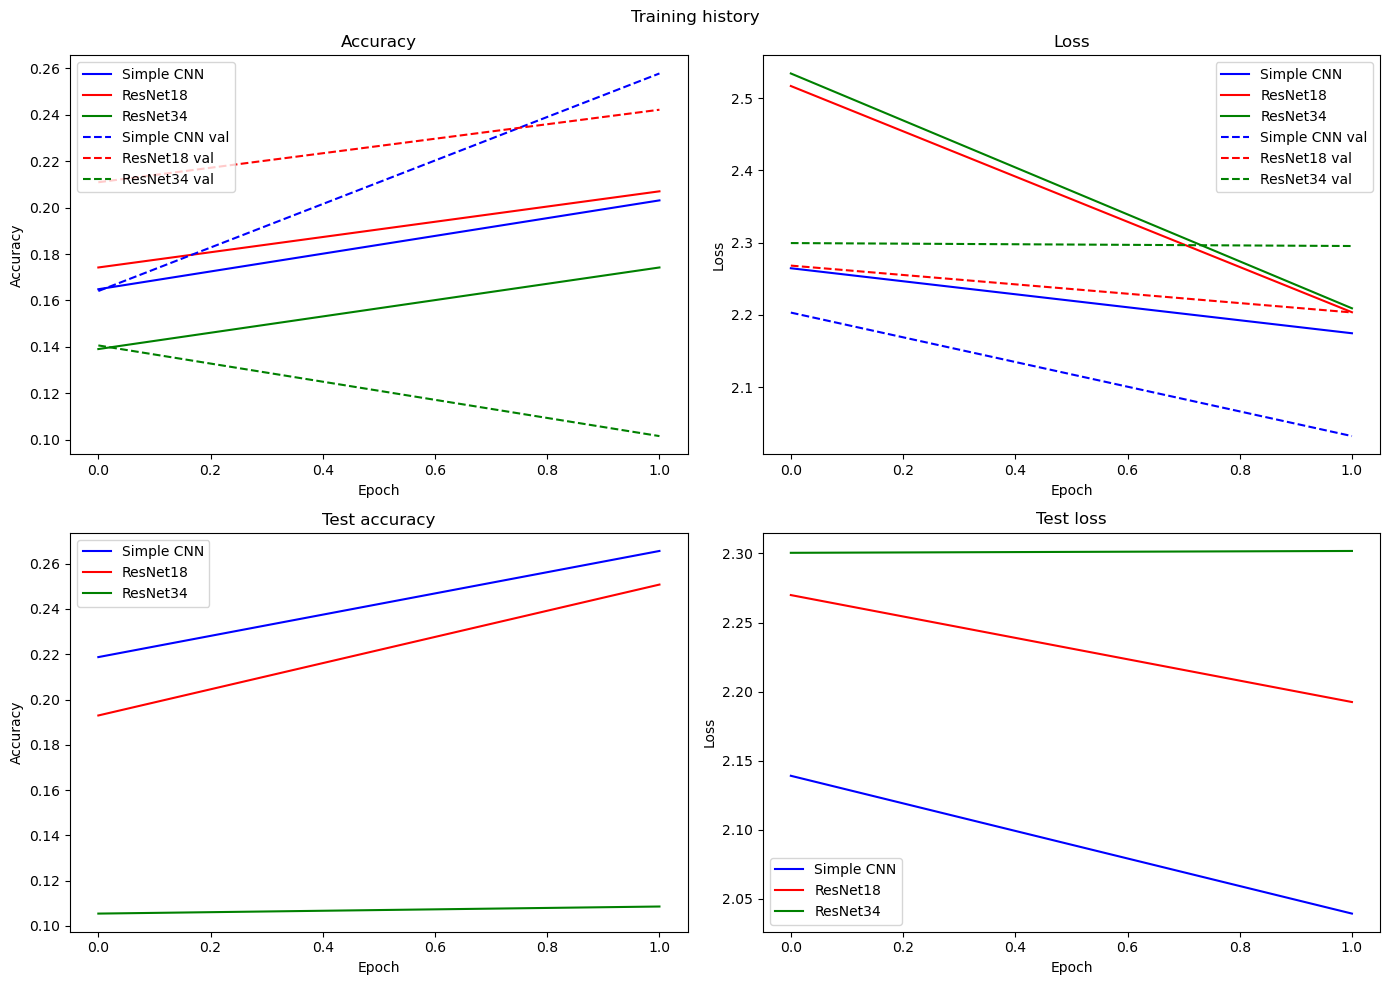

In [10]:
# plot the training history
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
fig.suptitle('Training history')
# accuracy
axes[0,0].plot(history_sCNN.history['accuracy'], label='Simple CNN', color='b')
axes[0,0].plot(history_res18.history['accuracy'], label='ResNet18', color='r')
axes[0,0].plot(history_res34.history['accuracy'], label='ResNet34', color='g')
axes[0,0].plot(history_sCNN.history['val_accuracy'], label='Simple CNN val', linestyle='dashed', color='b')
axes[0,0].plot(history_res18.history['val_accuracy'], label='ResNet18 val', linestyle='dashed', color='r')
axes[0,0].plot(history_res34.history['val_accuracy'], label='ResNet34 val', linestyle='dashed', color='g')
axes[0,0].set_title('Accuracy')
axes[0,0].set_xlabel('Epoch')
axes[0,0].set_ylabel('Accuracy')
axes[0,0].legend()

# loss 
axes[0,1].plot(history_sCNN.history['loss'], label='Simple CNN', color='b')
axes[0,1].plot(history_res18.history['loss'], label='ResNet18', color='r')
axes[0,1].plot(history_res34.history['loss'], label='ResNet34', color='g')
axes[0,1].plot(history_sCNN.history['val_loss'], label='Simple CNN val', linestyle='dashed', color='b')
axes[0,1].plot(history_res18.history['val_loss'], label='ResNet18 val', linestyle='dashed', color='r')
axes[0,1].plot(history_res34.history['val_loss'], label='ResNet34 val', linestyle='dashed', color='g')
axes[0,1].set_title('Loss')
axes[0,1].set_xlabel('Epoch')
axes[0,1].set_ylabel('Loss')
axes[0,1].legend()

# test accuracy
axes[1,0].plot(test_res_callback_sCNN.test_results['test_accuracy'], label='Simple CNN', color='b')
axes[1,0].plot(test_res_callback_res18.test_results['test_accuracy'], label='ResNet18', color='r')
axes[1,0].plot(test_res_callback_res34.test_results['test_accuracy'], label='ResNet34', color='g')
axes[1,0].set_title('Test accuracy')
axes[1,0].set_xlabel('Epoch')
axes[1,0].set_ylabel('Accuracy')
axes[1,0].legend()

# test loss
axes[1,1].plot(test_res_callback_sCNN.test_results['test_loss'], label='Simple CNN', color='b')
axes[1,1].plot(test_res_callback_res18.test_results['test_loss'], label='ResNet18', color='r')
axes[1,1].plot(test_res_callback_res34.test_results['test_loss'], label='ResNet34', color='g')
axes[1,1].set_title('Test loss')
axes[1,1].set_xlabel('Epoch')
axes[1,1].set_ylabel('Loss')
axes[1,1].legend()

plt.tight_layout()
plt.show()


2024-04-14 19:48:36.006318: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype string and shape [1]
	 [[{{node Placeholder/_1}}]]
2024-04-14 19:48:36.006733: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype string and shape [1]
	 [[{{node Placeholder/_2}}]]
2024-04-14 19:48:36.586570: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'input' with dtype float and shape [128,32,32,3]
	 [[{{n

Instructions for updating:
Use fn_output_signature instead


2024-04-14 19:48:37.016557: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'cond/input' with dtype float and shape [128,32,32,3]
	 [[{{node cond/input}}]]
Instructions for updating:
Use fn_output_signature instead


4/4 [==============================] - 0s 42ms/step


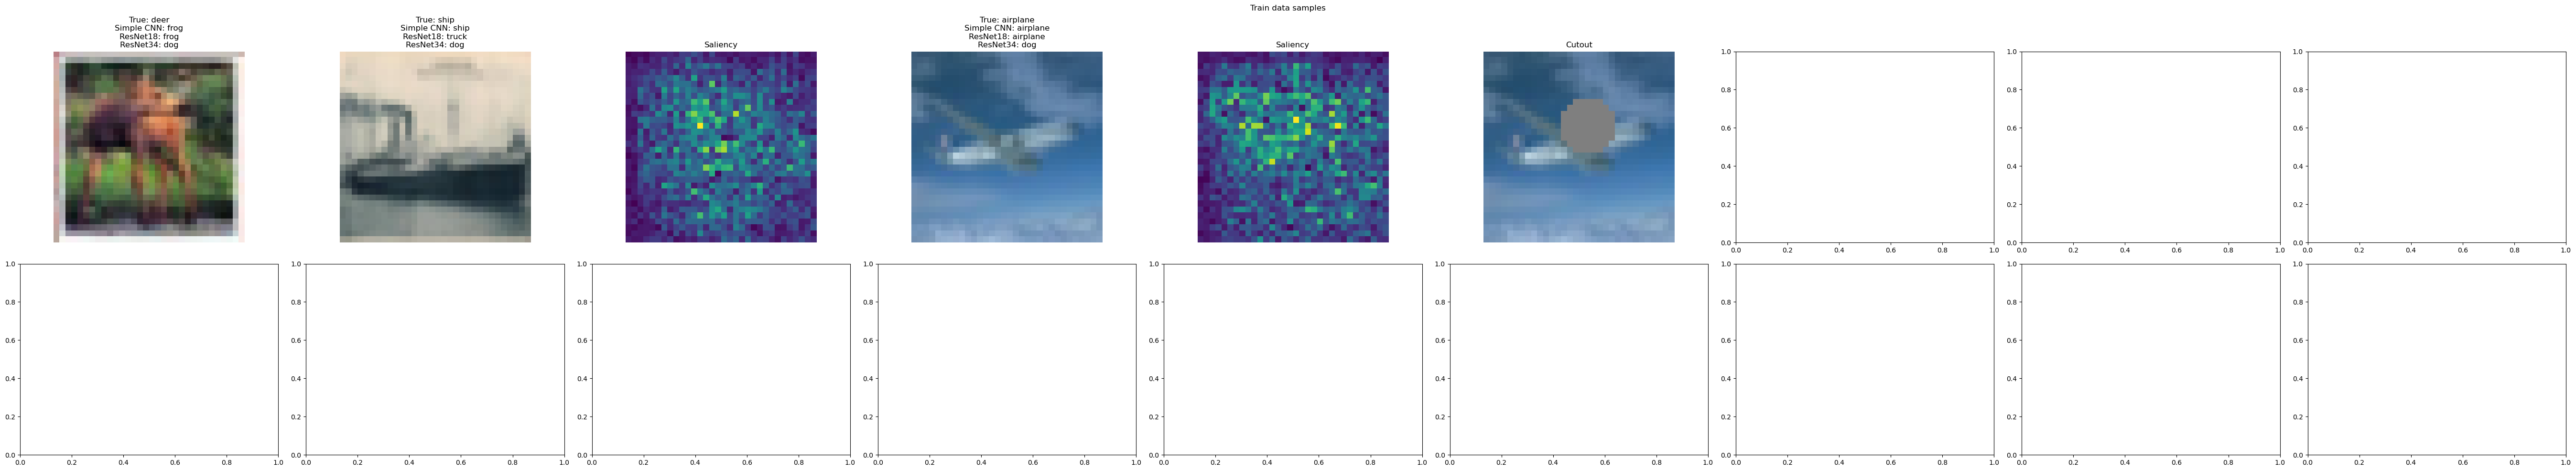

In [11]:
# Make a prediction with some test samples
# simple_CNN.load_weights('trained_models/simpleCNN.h5')
# res_net18.load_weights('trained_models/resnet18.h5')
# res_net34.load_weights('trained_models/resnet34.h5')

num_samples = 4
max_plots_per_row = 3  
num_columns = min(num_samples, max_plots_per_row)
num_rows = (num_samples + max_plots_per_row - 1) // max_plots_per_row 
fig_width = num_columns * 6
fig_height = num_rows * 5
# create the subplots
fig, axes = plt.subplots(num_rows, num_columns*3, figsize=(fig_width*3, fig_height))
fig.suptitle('Train data samples')
# flatten the array of axes
# ensure its an array in case of single sample
axes = np.asarray(axes).flatten()

dyn_cutout_layer = DynamicCutoutLayer(mask_size = 10, shape='circle', cutout_prob=1.0)
for i, (image, label) in enumerate(test_data.take(num_samples)):
    if (i+1) % 3 == 0:
      continue
    image_saliency = dyn_cutout_layer.get_network_attention((image, label), res_net18)
    image_cutout = dyn_cutout_layer((image, label), res_net18, training=True)
    axes[i].imshow((image[0] + 1) / 2)
    axes[i+1].imshow((image_saliency[0]+1) / 2)
    axes[i+2].imshow((image_cutout[0] + 1) / 2)
    # set the title to the int of the one-hot encoding
    pred_sCNN = simple_CNN.predict(image)
    pred_res18 = res_net18.predict(image)
    pred_res34 = res_net34.predict(image)
    true_label = label_names[np.argmax(label[0])]
    pred_label_sCNN = label_names[np.argmax(pred_sCNN[0])]
    pred_label_res18 = label_names[np.argmax(pred_res18[0])]
    pred_label_res34 = label_names[np.argmax(pred_res34[0])]
    label = f"True: {true_label}\nSimple CNN: {pred_label_sCNN}\nResNet18: {pred_label_res18}\nResNet34: {pred_label_res34}"
    axes[i].set_title(label)
    axes[i+1].set_title('Saliency')
    axes[i+2].set_title('Cutout')
    axes[i].axis('off')
    axes[i+1].axis('off')
    axes[i+2].axis('off')

plt.tight_layout()
plt.show()